# Quantum State Preparation: Real Data Loader Example

In this notebook, we implement and simulate a **quantum state preparation algorithm** based on a
recursive divide-and-conquer approach, inspired by:
> Araujo I, Park D, Petruccione F, da Silva AJ.  
> A divide-and-conquer algorithm for quantum state preparation.  
> *Scientific Reports* 2021;11:6329.

The objective is to encode a real probability distribution into a quantum state using a specific
set of rotation angles computed from the square roots of the probabilities.
This is a foundational task in quantum machine learning and quantum data loading.

In [1]:
import numpy as np

from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import RYGate
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram

## Recursive Angle Generator

The `gen_angles` function computes a series of rotation angles to prepare a quantum state
that encodes the desired amplitude vector. It works by recursively grouping and reducing
adjacent amplitudes, then computing the angles needed to combine them through controlled RY gates.

In [2]:
def gen_angles(x):
    N = int(len(x))
    Nd2 = int(N / 2)
    new_x = np.zeros(Nd2)

    if N > 1:
        for k in range(Nd2):
            new_x[k] = np.sqrt(x[2 * k]**2 + x[2 * k + 1]**2)

        inner_angles = gen_angles(new_x)

        angles = np.zeros(Nd2)
        for k in range(Nd2):
            if new_x[k] != 0:
                if x[2 * k] > 0:
                    angles[k] = 2 * np.arcsin(x[2 * k + 1] / new_x[k])
                else:
                    angles[k] = 2 * np.pi - 2 * np.arcsin(x[2 * k + 1] / new_x[k])
            else:
                angles[k] = 0

        if N > 2:
            angles = np.concatenate((inner_angles, angles))

        return angles

print("Defined gen_angles(x)")

Defined gen_angles(x)


## Quantum Circuit Generator
This function takes the calculated angles and builds a quantum circuit by applying
single and multi-controlled RY rotations. Each layer of control increases the depth of encoding,
allowing the circuit to represent the correct amplitudes in the final state.

In [3]:
def gen_circuit(angles):
    N = int(len(angles))+1
    n = np.log2(N)

    circuit = QuantumCircuit(n)

    circuit.ry(angles[0], 0)

    circuit.x(0)
    circuit.cry(angles[1], 0, 1)
    circuit.x(0)
    circuit.cry(angles[2], 0, 1)

    circuit.x(0)
    circuit.x(1)
    c2ry = RYGate(angles[3]).control(2)
    circuit.append(c2ry, [0, 1, 2])
    circuit.x(0)
    circuit.x(1)

    circuit.x(0)
    c2ry = RYGate(angles[4]).control(2)
    circuit.append(c2ry, [0, 1, 2])
    circuit.x(0)
        
    circuit.x(1)
    c2ry = RYGate(angles[5]).control(2)
    circuit.append(c2ry, [0, 1, 2])
    circuit.x(1)
        
    c2ry = RYGate(angles[6]).control(2)
    circuit.append(c2ry, [0, 1, 2])

    return circuit

print("Defined gen_circuit(angles)")

Defined gen_circuit(angles)


## Input Distribution and Angle Calculation

Define the classical probability distribution you want to encode.
In practice, these might come from a real-world dataset.

Target probabilities:
[0.169194173824, 0.1875, 0.169194173824, 0.125, 0.080805826176, 0.0625, 0.080805826176, 0.125]


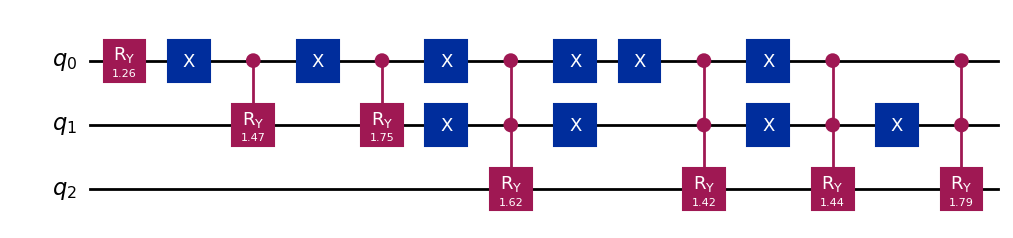

In [4]:
# Classical probabilities to be encoded
p = [0.169194173824, 0.1875, 0.169194173824, 0.125,
     0.080805826176, 0.0625, 0.080805826176, 0.125]

print("Target probabilities:")
print(p)

# Convert to amplitude vector
x = np.sqrt(p)

# Generate RY angles
angles = gen_angles(x)

# Generate the quantum circuit
circuit = gen_circuit(angles)
circuit.draw("mpl")

## Circuit Execution

We measure all qubits and transpile the circuit to conform with basic backend constraints
(e.g., all gates are decomposed into 1- and 2-qubit gates).

Then we simulate the execution on `BasicSimulator`.

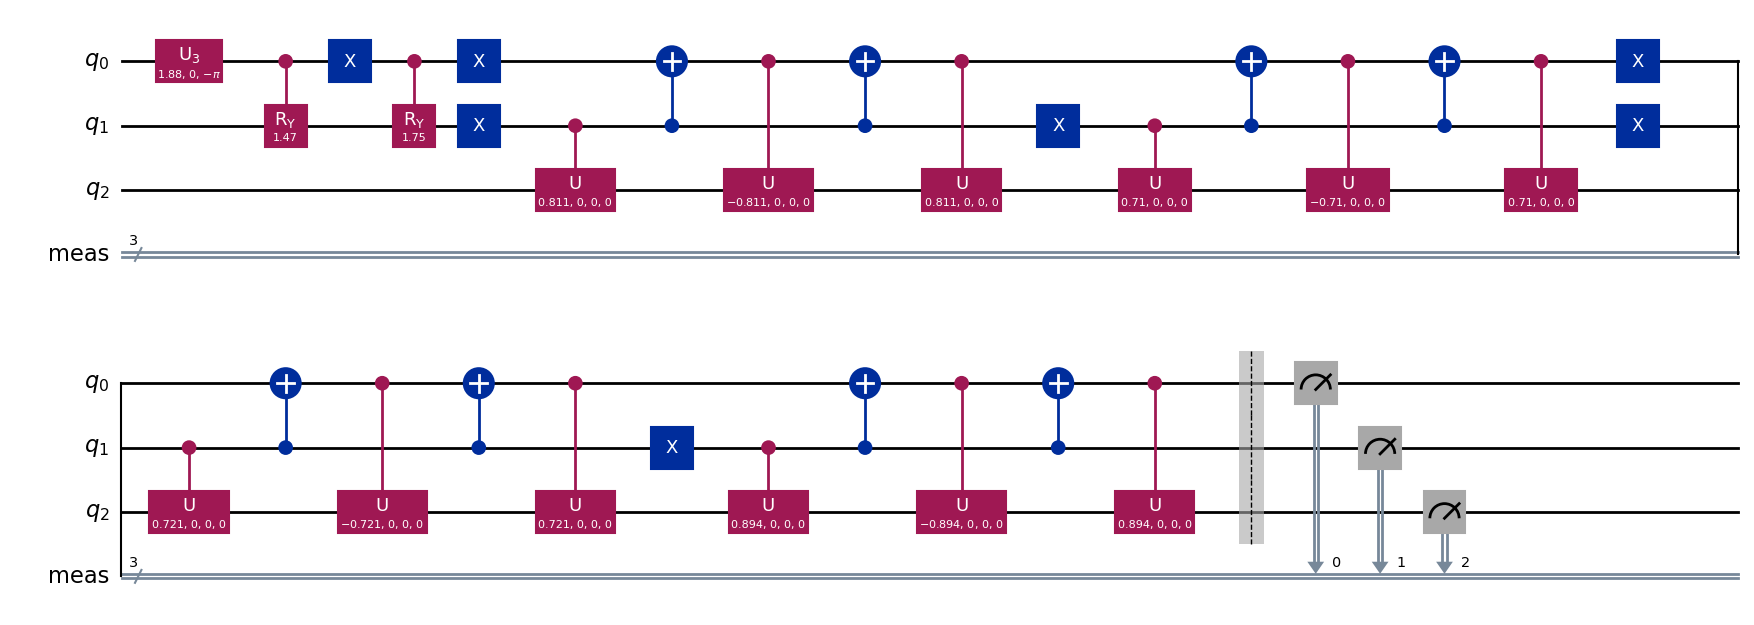

In [5]:
# Add measurements
circuit.measure_all()

# Transpile the circuit
backend = BasicSimulator()
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
circuit_combine = pm.run(circuit)
circuit_combine.draw("mpl")

## Execute and Compare Output Distribution

**Caution, ordering**:

The video linked above and many physics textbooks 
use the Big Endian convention, where qubits in a multi-qubit system 
are ordered from the least to most significant qubit as

$\ket{q0 q1 … q(n-1)}$. 

Qiskit uses the Little Endian convention

$\ket{q(n-1)… q1q0}$

by default.

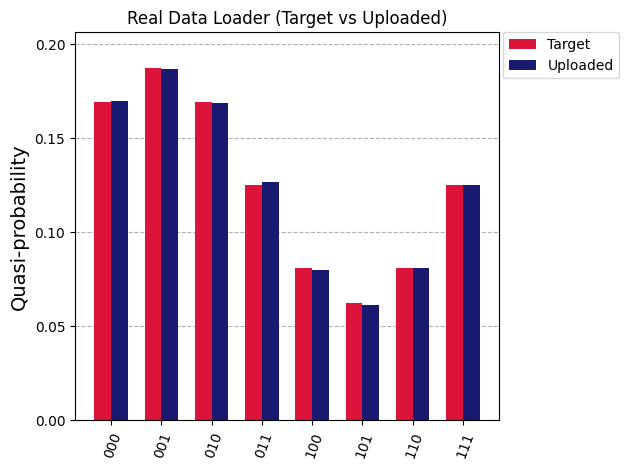

In [6]:
# Execute the circuit
N_shots = 100000
result = backend.run(circuit_combine.reverse_bits(), shots=N_shots).result()
counts = result.get_counts()

# Expected counts from probabilities
valth = N_shots * np.array(p)
countsth = {f"{i:03b}": int(val) for i, val in enumerate(valth)}
pth = {f"{i:03b}": prob for i, prob in enumerate(p)}

legend = ['Target', 'Uploaded']

# Visualize quasi-probability
plot_histogram([pth, counts], legend=legend, color=['crimson', 'midnightblue'],
               title="Real Data Loader (Target vs Uploaded)", bar_labels=False)